In [1]:

import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow.keras as tfk
import xlrd
import numpy as np
import nltk
from nltk.corpus import stopwords
import sys
import string
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12439584449334028375
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1416668364
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14713685498939016393
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


True

In [15]:
train = xlrd.open_workbook('train_data_final.xlsx')
test = xlrd.open_workbook('test_data_finak.xlsx')
trainsheet = train.sheet_by_index(0)
testsheet = test.sheet_by_index(0)
pub = []
pub_t = []
content = []
content_t = []
indeces = list(range(trainsheet.nrows -1))
indeces_t = list(range(testsheet.nrows -1))
np.random.shuffle(indeces)
for r in indeces:
    pub.append(trainsheet.cell_value(r,0))
    content.append(trainsheet.cell_value(r,1))
for r in indeces_t:
    pub_t.append(testsheet.cell_value(r,0))
    content_t.append(testsheet.cell_value(r,1))

FileNotFoundError: [Errno 2] No such file or directory: 'test_data_finak.xlsx'

In [ ]:
stop = stopwords.words('english')
vocab = 50000


In [ ]:
content_arrs = []
content_arrs_t = []
i = 0
for con in content:
    contentClean = ' '.join([word for word in nltk.word_tokenize(con.lower()) if word not in stop and (word.isalpha() or len(word) > 1)])
    content_arrs.append(tfk.preprocessing.text.one_hot(contentClean, n=vocab))
    sys.stdout.write("\r" + str(i))
    sys.stdout.flush()
    i += 1
    
for con in content_t:
    contentClean = ' '.join([word for word in nltk.word_tokenize(con.lower()) if word not in stop and (word.isalpha() or len(word) > 1)])
    content_arrs_t.append(tfk.preprocessing.text.one_hot(contentClean, n=vocab))
    sys.stdout.write("\r" + str(i))
    sys.stdout.flush()
    i += 1

In [21]:
targetMap, pub = np.unique(pub, return_inverse=True)
print(targetMap)
'''for i in range(len(pub_t)):
    x = pub_t[i]
    pub_t[i] = targetMap[pub_t[i]]'''
    
long = 0
for con in content_arrs:
    if len(con) > long:
        long = len(con)
        
for con in content_arrs_t:
    if len(con) > long:
        long = len(con)
long = 750
padded_arrs = tfk.preprocessing.sequence.pad_sequences(content_arrs, maxlen=long, padding='post')
padded_arrs_t = tfk.preprocessing.sequence.pad_sequences(content_arrs_t, maxlen=long, padding='post')


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [22]:
print(pub)

[ 1  6  4 ...  8 14  7]


In [23]:
#RNN
#with tf.device('/cpu:0'):
model = tfk.models.Sequential()
model.add(tfk.layers.Embedding(vocab, 100, input_length=long))
model.add(tfk.layers.Dropout(.7))
model.add(tfk.layers.CuDNNGRU(40, return_sequences=True))
model.add(tfk.layers.CuDNNGRU(40))
model.add(tfk.layers.Dropout(.7))

#model.add(tfk.layers.CuDNNLSTM(50))
#model.add(tfk.layers.Dense(128, activation = 'relu'))
model.add(tfk.layers.Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [72]:
#CNN
with tf.device('/cpu:0'):
    model = tfk.models.Sequential()
    model.add(tfk.layers.Embedding(vocab, 100, input_length=long))
    model.add(tfk.layers.Conv1D(128, 5, activation = 'relu'))
    model.add(tfk.layers.MaxPooling1D(5))
    model.add(tfk.layers.Conv1D(128, 5, activation = 'relu'))
    model.add(tfk.layers.MaxPooling1D(5))
    model.add(tfk.layers.Conv1D(128, 5, activation = 'relu'))
    model.add(tfk.layers.MaxPooling1D(35))
    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dense(128, activation = 'relu'))
    model.add(tfk.layers.Dense(15, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


ValueError: Negative dimension size caused by subtracting 35 from 15 for 'max_pooling1d_20/MaxPool' (op: 'MaxPool') with input shapes: [?,15,1,128].

In [24]:
print('Begin fit')
print(np.shape(padded_arrs))
print(padded_arrs)
history = model.fit(padded_arrs, tfk.utils.to_categorical(pub), batch_size=50, epochs=10, validation_split=0.2, shuffle=True, verbose=1)

Begin fit
(98711, 750)
[[38623 32414 14385 ...     0     0     0]
 [ 6982 41421 48088 ...     0     0     0]
 [20735 41736  7707 ...     0     0     0]
 ...
 [47025 39576 45479 ...     0     0     0]
 [42489 29524 33340 ...     0     0     0]
 [40457   619 17227 ...     0     0     0]]
Train on 78968 samples, validate on 19743 samples
Epoch 1/10
78968/78968 [==============================] - 143s 2ms/sample - loss: 2.5557 - acc: 0.1750 - val_loss: 2.4604 - val_acc: 0.2045
Epoch 2/10
78968/78968 [==============================] - 143s 2ms/sample - loss: 2.4105 - acc: 0.2254 - val_loss: 2.1735 - val_acc: 0.2730
Epoch 3/10
78968/78968 [==============================] - 142s 2ms/sample - loss: 1.7500 - acc: 0.4418 - val_loss: 1.2363 - val_acc: 0.6173
Epoch 4/10
78968/78968 [==============================] - 143s 2ms/sample - loss: 1.2474 - acc: 0.6197 - val_loss: 1.1124 - val_acc: 0.6508
Epoch 5/10
78968/78968 [==============================] - 142s 2ms/sample - loss: 1.0697 - acc: 0.6723 

ValueError: invalid literal for int() with base 10: 'New York Times'

In [ ]:
loss, accuracy = model.evaluate(padded_arrs_t, tfk.utils.to_categorical(pub_t), verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss))

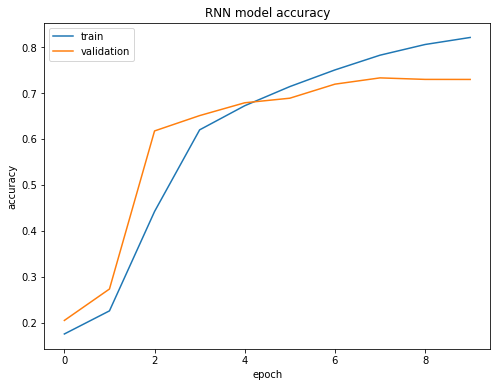

[0.17502026, 0.22536977, 0.44179922, 0.6197067, 0.6722596, 0.71397275, 0.7502279, 0.7823422, 0.8056555, 0.82096547]
[0.20452818, 0.2729575, 0.6173327, 0.6507623, 0.67867094, 0.6886491, 0.7192423, 0.732918, 0.7296257, 0.7295244]
[2.555727337117664, 2.410461750074356, 1.7500334769176404, 1.2473650901495246, 1.0696674471519334, 0.9355624431945937, 0.83385475793169, 0.741817857388178, 0.6713544830559881, 0.6147605180276158]
[2.4603912223166127, 2.1735496192284463, 1.2363152346072188, 1.1124388475956202, 1.0234261311574444, 1.0234940032589939, 0.9677955877610037, 0.9620284292419915, 1.0241035060009949, 1.0635883820604566]


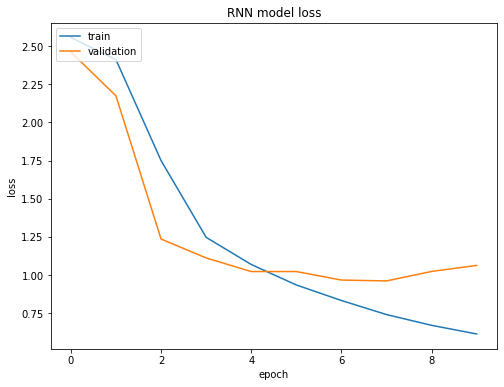

In [26]:
from matplotlib import pyplot as plt
print(history)
plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('RNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(history.history['acc'])
print(history.history['val_acc'])
print(history.history['loss'])
print(history.history['val_loss'])
# summarize history for loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
test = xlrd.open_workbook('test_data_mod_new.xlsx')
testsheet = test.sheet_by_index(0)
pub = []
content = []
for r in range(0, testsheet.nrows -1):
    pub.append(testsheet.cell_value(r,0))
    content.append(testsheet.cell_value(r,1))
loss, accuracy = model.evaluate(padded_arrs, tfk.utils.to_categorical(pub), verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
[0.18154539, 0.22930732, 0.31457865, 0.40585145, 0.49812454, 0.5866467, 0.65591395, 0.7329332, 0.8134534, 0.8567142]
[0.167, 0.238, 0.274, 0.304, 0.274, 0.244, 0.313, 0.291, 0.275, 0.306]
[2.5657440520847223, 2.348019083966968, 2.120584200012234, 1.823251846045904, 1.5280263197663486, 1.258662076972967, 1.0170799186152797, 0.8282619516203839, 0.569817375319992, 0.4606405908866476]
[2.701296714782715, 2.3249752082824706, 2.285276750564575, 2.447434419631958, 2.4535061569213865, 3.28255184173584, 3.0558393154144285, 3.2090130558013916, 4.6331355781555175, 4.420660408020019]